In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from pathlib import Path
import os
from scipy.spatial import ConvexHull

In [3]:
#pydrake imports
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.solvers import MathematicalProgram, Solve
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint
from pydrake.all import RotationMatrix
import pydrake.symbolic as sym
import time
from pydrake.all import CspaceFreeLine, CspaceFreeRegion
import pydrake.multibody.rational_forward_kinematics as rational_forward_kinematics
from pydrake.all import VerificationOption

from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import IrisOptionsRationalSpace, IrisInRationalConfigurationSpace, HPolyhedron, Hyperellipsoid

In [4]:
import logging
drake_logger = logging.getLogger("drake")
drake_logger.setLevel("DEBUG")


In [5]:
num_vars = 2
var_list = sym.MakeVectorContinuousVariable(num_vars, "x")
vars_obj = sym.Variables(var_list)

deg = 1

basis = sym.MonomialBasis(var_list, deg)
print(type(basis))

<class 'numpy.ndarray'>


In [6]:
def build_polytope_intersection_program_strict_convex_hull(P_poly, Q_poly, env):
    P = sym.Evaluate(P_poly, env)
    Q = sym.Evaluate(Q_poly, env)
    prog = MathematicalProgram()
    lam = prog.NewContinuousVariables(P.shape[0], "lam")
    nu = prog.NewContinuousVariables(Q.shape[0], "nu")
    
    prog.AddLinearConstraint(np.eye(lam.shape[0]), np.zeros_like(lam), np.inf*np.ones_like(lam), lam)
    prog.AddLinearConstraint(np.eye(nu.shape[0]), np.zeros_like(nu), np.inf*np.ones_like(nu), nu)
    
    prog.AddLinearEqualityConstraint(np.ones((1,lam.shape[0])),np.array([1]), lam)
    prog.AddLinearEqualityConstraint(np.ones((1,nu.shape[0])), np.array([1]), nu)
    
    prog.AddLinearEqualityConstraint(np.vstack([P, -Q]).T, np.zeros(P.shape[1]), np.concatenate([lam, nu]))
    
    return prog

def build_polytope_intersection_program_nonstrict_convex_hull(P_poly, Q_poly, env):
    P = sym.Evaluate(P_poly, env)
    Q = sym.Evaluate(Q_poly, env)
    prog = MathematicalProgram()
    lam = prog.NewContinuousVariables(P.shape[0], "lam")
    nu = prog.NewContinuousVariables(Q.shape[0], "nu")
    
    eps = 1e-3
    
    prog.AddLinearConstraint(np.eye(lam.shape[0]), eps*np.ones_like(lam), np.inf*np.ones_like(lam), lam)
    prog.AddLinearConstraint(np.eye(nu.shape[0]), eps*np.ones_like(nu), np.inf*np.ones_like(nu), nu)
    
#     prog.AddLinearConstraint(np.eye(lam.shape[0]), np.zeros_like(lam), np.inf*np.ones_like(lam), lam)
#     prog.AddLinearConstraint(np.eye(nu.shape[0]), np.zeros_like(nu), np.inf*np.ones_like(nu), nu)
    
    prog.AddLinearEqualityConstraint(np.hstack([np.ones((1,lam.shape[0])), -np.ones((1,nu.shape[0]))]),
                                                np.array([0]), np.concatenate([lam,nu]))
    
    prog.AddLinearEqualityConstraint(np.vstack([P, -Q]).T, np.zeros(P.shape[1]), np.concatenate([lam, nu]))
    
    return prog

def polytopes_intersect(P_poly, Q_poly, env, strict = True):
    builder = build_polytope_intersection_program_strict_convex_hull if strict else build_polytope_intersection_program_nonstrict_convex_hull
    prog = builder(P_poly, Q_poly, env)
    result = Solve(prog)
    return result.is_success(), result, prog

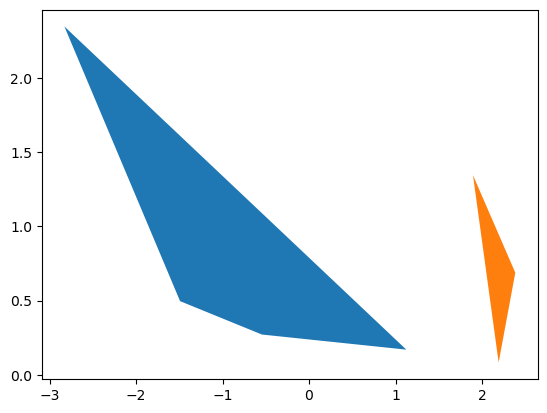

DEBUG:drake:solvers::Solve will use Mosek
DEBUG:drake:solvers::Solve will use Mosek


False
False


In [7]:
dim = 2
# np.random.seed(1)

num_verts_p = 4
P_poly = np.random.randn(num_verts_p, dim, basis.shape[0]) @ basis

num_verts_q = 3
Q_poly = np.random.randn(num_verts_q, dim, basis.shape[0]) @ basis

def plot_polytopes_at_val(P_poly, Q_poly, env):
    P = sym.Evaluate(P_poly, env)
    Q = sym.Evaluate(Q_poly, env)
    P_hull = ConvexHull(P) #np.zeros((3, num_verts_p))
    Q_hull = ConvexHull(Q) #np.zeros((3, num_verts_q))
    plt.fill(P[P_hull.vertices, 0], P[P_hull.vertices, 1])
    plt.fill(Q[Q_hull.vertices, 0], Q[Q_hull.vertices, 1])
    plt.show()

env = {k: np.random.randn(1).item() for k  in var_list}
plot_polytopes_at_val(P_poly, Q_poly, env)

does_intersect_strict, result_strict, prog_strict = polytopes_intersect(P_poly, Q_poly, env, strict = True)
does_intersect_nonstrict, result_nonstrict, prog_nonstrict = polytopes_intersect(P_poly, Q_poly, env, strict = False)
print(does_intersect_strict)
print(does_intersect_nonstrict)

In [8]:
print(result_strict.get_x_val())

[0. 0. 0. 0. 0. 0. 0.]


In [9]:
print(result_nonstrict.get_x_val())

[0. 0. 0. 0. 0. 0. 0.]
